# Jupyter Notebook Shortcuts

In [ ]:
### Execution
# Shift+Enter: Execute cell, move to next cell

### Toggling Command/Edit Mode
# Esc: Edit Mode -> Command Mode
# Enter: Command Mode -> Edit Mode

### While in Command Mode
# A: Create cell ABOVE
# B: Create cell BELOW
# D+D: Delete cell
# M: Switch to Markdown
# Y: Switch to Code
# O: Toggle output show/hide

# Setup

In [1]:
import sys
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --yes --prefix {sys.prefix} -c conda-forge fbprophet
# !conda install --yes --prefix {sys.prefix} xgboost
# !conda install --yes --prefix {sys.prefix} scikit-learn

In [24]:
# General Packages
import sqlite3
import pandas as pd
import numpy as np
import time
import datetime
import copy
import warnings
import matplotlib
import matplotlib.pyplot as plt

# Modeling Packages
import sklearn
import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import xgboost as xgb

# Jupyter settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
warnings.simplefilter('ignore')

def disp(df, lines = 5, type='head'):
    print(df.shape)
    if type == 'head':
        display(df.head(lines))
    elif type == 'tail':
        display(df.tail(lines))
    else:
        print("Error: Please enter either 'head' or 'tail'.")

class Clock:
    def __init__(self):
        self.start_time = 0
        
    def start(self):
        self.start_time = time.time()

    def stop(self):
        print(round(time.time() - self.start_time, 5))
        
c = Clock()

In [10]:
query_rides_a = '''
    SELECT *
    FROM rides_a
'''

query_rides_b = '''
    SELECT *
    FROM rides_b
'''

query_weather = '''
    SELECT *
    FROM weather
'''

In [11]:
conn = sqlite3.connect('msda_workshop')
rides_a_df = pd.read_sql_query(query_rides_a, conn)
rides_b_df = pd.read_sql_query(query_rides_b, conn)
weather_df = pd.read_sql_query(query_weather, conn)
conn.close()

In [15]:
rides_a_df.head()

,RIDE_ID,started_on,created_date,updated_date,completed_on,distance_travelled,end_location_lat,end_location_long,driver_rating,rider_rating,...,charity_id,requested_car_category,free_credit_used,surge_factor,start_location_long,start_location_lat,rider_id,round_up_amount,promocode_redemption_id,driver_reached_on
0,0,2016-06-04 00:18:49-05:00,2016-06-04 00:10:19-05:00,2016-06-04 00:27:48-05:00,2016-06-04 00:27:32-05:00,8459.0,38.676,-121.039,5.0,5.0,...,,b'REGULAR',,0.0,-121.071,38.655,0,,,2016-06-04 00:14:11-05:00
1,1,2016-06-04 01:50:12-05:00,2016-06-04 01:47:39-05:00,2016-06-04 01:52:00-05:00,2016-06-04 01:51:49-05:00,443.0,38.676,-121.039,5.0,5.0,...,,b'REGULAR',,0.0,-121.038,38.679,0,,,2016-06-04 01:50:02-05:00
2,2,2016-06-04 03:16:02-05:00,2016-06-04 03:13:07-05:00,2016-06-04 03:18:07-05:00,2016-06-04 03:17:57-05:00,568.0,38.676,-121.039,3.0,5.0,...,,b'REGULAR',,0.0,-121.042,38.678,0,,,2016-06-04 03:16:01-05:00
3,3,2016-06-04 10:05:13-05:00,2016-06-04 09:52:35-05:00,2016-06-04 10:14:00-05:00,2016-06-04 10:13:38-05:00,4051.0,30.271,-97.742,5.0,5.0,...,,b'REGULAR',,0.0,-97.764,30.247,1,,,2016-06-04 10:01:19-05:00
4,4,2016-06-04 10:24:25-05:00,2016-06-04 10:23:25-05:00,2016-06-04 10:26:16-05:00,2016-06-04 10:26:07-05:00,790.0,30.269,-97.752,5.0,5.0,...,,b'REGULAR',,0.0,-97.75,30.269,2,,,2016-06-04 10:24:15-05:00


In [13]:
rides_b_df.head()

,RIDE_ID,base_fare,total_fare,rate_per_mile,rate_per_minute,time_fare,driver_accepted_on,esimtated_time_arrive,tipped_on,tip,...,dispatched_on,status,driver_id,car_id,color,make,model,year,car_categories_bitmask,rating
0,0,1.5,25.84,1.5,0.25,2.18,,,,,...,2016-06-04 05:10:19,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
1,1,1.5,5.0,1.5,0.25,0.41,,,,,...,2016-06-04 06:47:39,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
2,2,1.5,5.0,1.5,0.25,0.48,,,,,...,2016-06-04 08:13:07,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
3,3,1.5,8.93,1.5,0.25,2.11,,,,,...,2016-06-04 14:52:35,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0
4,4,1.5,5.0,1.5,0.25,0.43,,,,,...,2016-06-04 15:23:25,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0


In [14]:
weather_df.head()

,RIDE_ID,HOURLYVISIBILITY,HOURLYDRYBULBTEMPC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYPrecip,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYAverageRelativeHumidity,DAILYSunrise,DAILYSunset,DAILYPrecip,DAILYAverageWindSpeed,DAILYPeakWindSpeed
0,0,8.75,20.700000000000003,94.0,6.0,13.333333333333334,0.0,,,,,529.0,1930.0,1.63,,
1,1,6.0,21.1,93.0,1.5,0.0,0.0,,,,,529.0,1930.0,,,
2,2,10.0,23.03333333333333,88.0,5.0,350.0,,,,,,529.0,1930.0,,,
3,3,10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,
4,4,10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,


In [128]:
start_time = time.time()

query_rides = '''
    SELECT
         a.RIDE_ID                      AS ride_id
        ,DATE(created_date)             AS date
        ,distance_travelled             AS distance
        ,start_location_lat             AS start_lat
        ,start_location_long            AS start_long
        ,end_location_lat               AS end_lat
        ,end_location_long              AS end_long
        ,round_up_amount                AS charity_amount
        ,status                         AS status
        ,requested_car_category         AS car_category
        ,make                           AS car_make
        ,model                          AS car_model
        ,HOURLYVISIBILITY               AS hourly_visibility
        ,HOURLYDRYBULBTEMPC             AS hourly_temp
        ,HOURLYRelativeHumidity         AS hourly_humidity
        ,HOURLYWindSpeed                AS hourly_wind_speed
        ,HOURLYWindDirection            AS hourly_wind_direction
        ,HOURLYPrecip                   AS hourly_precip
        ,DAILYMaximumDryBulbTemp        AS daily_temp_max
        ,DAILYMinimumDryBulbTemp        AS daily_temp_min
        ,DAILYDeptFromNormalAverageTemp AS daily_temp_departure
        ,DAILYAverageRelativeHumidity   AS daily_humidity
        ,DAILYSunrise                   AS daily_sunrise
        ,DAILYSunset                    AS daily_sunset
        ,DAILYPrecip                    AS daily_precip
        ,DAILYAverageWindSpeed          AS daily_wind_speed_avg
        ,DAILYPeakWindSpeed             AS daily_wind_spead_peak
    FROM rides_a a
        INNER JOIN rides_b b
            ON a.RIDE_ID = b.RIDE_ID
        INNER JOIN weather w
            ON a.RIDE_ID = w.RIDE_ID
'''

conn = sqlite3.connect('msda_workshop')
# rides_df = pd.read_sql_query(query_rides, conn)
rides_df = pd.read_sql_query(query_rides, conn)
conn.close()

disp(rides_df)

print(time.time() - start_time)

(1494125, 27)


,ride_id,date,distance,start_lat,start_long,end_lat,end_long,charity_amount,status,car_category,car_make,car_model,hourly_visibility,hourly_temp,hourly_humidity,hourly_wind_speed,hourly_wind_direction,hourly_precip,daily_temp_max,daily_temp_min,daily_temp_departure,daily_humidity,daily_sunrise,daily_sunset,daily_precip,daily_wind_speed_avg,daily_wind_spead_peak
0,0,2016-06-04,8459.0,38.655,-121.071,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',8.75,20.700000000000003,94.0,6.0,13.333333333333334,0.0,,,,,529.0,1930.0,1.63,,
1,1,2016-06-04,443.0,38.679,-121.038,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',6.0,21.1,93.0,1.5,0.0,0.0,,,,,529.0,1930.0,,,
2,2,2016-06-04,568.0,38.678,-121.042,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',10.0,23.03333333333333,88.0,5.0,350.0,,,,,,529.0,1930.0,,,
3,3,2016-06-04,4051.0,30.247,-97.764,30.271,-97.742,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,
4,4,2016-06-04,790.0,30.269,-97.75,30.269,-97.752,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,


36.725362062454224


In [ ]:
yyyy-mm-dd hh:mm:ss-hh:mm

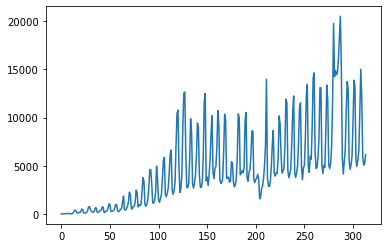

In [41]:
days_df['rides'].plot()

In [25]:
df.columns

Index(['RIDE_ID', 'started_on', 'created_date', 'updated_date', 'completed_on', 'distance_travelled', 'end_location_lat', 'end_location_long', 'driver_rating', 'rider_rating', 'active_driver_id', 'charity_id', 'requested_car_category', 'free_credit_used', 'surge_factor', 'start_location_long', 'start_location_lat', 'rider_id', 'round_up_amount', 'promocode_redemption_id', 'driver_reached_on', 'RIDE_ID', 'base_fare', 'total_fare', 'rate_per_mile', 'rate_per_minute', 'time_fare', 'driver_accepted_on', 'esimtated_time_arrive', 'tipped_on', 'tip', 'driving_time_to_rider', 'dispatch_location_lat', 'dispatch_location_long', 'driving_distance_to_rider', 'dispatched_on', 'status', 'driver_id', 'car_id', 'color', 'make', 'model', 'year', 'car_categories_bitmask', 'rating', 'RIDE_ID', 'HOURLYVISIBILITY', 'HOURLYDRYBULBTEMPC', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed', 'HOURLYWindDirection', 'HOURLYPrecip', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp', 'DAILYDeptFromNormalAverageTemp',


In [130]:
rides_df['car_category'].value_counts()

b'REGULAR'    1419521
b'SUV'          54784
b'PREMIUM'      13967
b'LUXURY'        4340
b'HONDA'         1513
Name: car_category, dtype: int64

# Preprocessing

In [132]:
# Turn empty strings to NULLs
num_cols = [col for col in rides_df.columns if 'daily' in col]
for col in num_cols:
    rides_df.loc[rides_df[col] == '', col] = np.nan

In [133]:
disp(rides_df)

(1494125, 27)


,ride_id,date,distance,start_lat,start_long,end_lat,end_long,charity_amount,status,car_category,car_make,car_model,hourly_visibility,hourly_temp,hourly_humidity,hourly_wind_speed,hourly_wind_direction,hourly_precip,daily_temp_max,daily_temp_min,daily_temp_departure,daily_humidity,daily_sunrise,daily_sunset,daily_precip,daily_wind_speed_avg,daily_wind_spead_peak
0,0,2016-06-04,8459.0,38.655,-121.071,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',8.75,20.700000000000003,94.0,6.0,13.333333333333334,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,1.63,NaN,NaN
1,1,2016-06-04,443.0,38.679,-121.038,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',6.0,21.1,93.0,1.5,0.0,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN
2,2,2016-06-04,568.0,38.678,-121.042,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',10.0,23.03333333333333,88.0,5.0,350.0,,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN
3,3,2016-06-04,4051.0,30.247,-97.764,30.271,-97.742,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN
4,4,2016-06-04,790.0,30.269,-97.75,30.269,-97.752,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN


In [134]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494125 entries, 0 to 1494124
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   ride_id                1494125 non-null  object
 1   date                   1494125 non-null  object
 2   distance               1494125 non-null  object
 3   start_lat              1494125 non-null  object
 4   start_long             1494125 non-null  object
 5   end_lat                1494125 non-null  object
 6   end_long               1494125 non-null  object
 7   charity_amount         1494125 non-null  object
 8   status                 1494125 non-null  object
 9   car_category           1494125 non-null  object
 10  car_make               1494125 non-null  object
 11  car_model              1494125 non-null  object
 12  hourly_visibility      1494125 non-null  object
 13  hourly_temp            1494125 non-null  object
 14  hourly_humidity        1494125 non

In [164]:
start_time = time.time()

query = '''
    WITH rides AS (
        SELECT
             a.RIDE_ID                      AS ride_id
            ,DATE(created_date)             AS date
            ,SUBSTR(created_date, 11, 2)    AS hour
            ,distance_travelled             AS distance
            ,start_location_lat             AS start_lat
            ,start_location_long            AS start_long
            ,end_location_lat               AS end_lat
            ,end_location_long              AS end_long
            ,round_up_amount                AS charity_amount
            ,status                         AS status
            ,requested_car_category         AS car_category
            ,make                           AS car_make
            ,model                          AS car_model
            ,HOURLYVISIBILITY               AS hourly_visibility
            ,HOURLYDRYBULBTEMPC             AS hourly_temp
            ,HOURLYRelativeHumidity         AS hourly_humidity
            ,HOURLYWindSpeed                AS hourly_wind_speed
            ,HOURLYWindDirection            AS hourly_wind_direction
            ,HOURLYPrecip                   AS hourly_precip
        FROM rides_a a
            INNER JOIN rides_b b
                ON a.RIDE_ID = b.RIDE_ID
            INNER JOIN weather w
                ON a.RIDE_ID = w.RIDE_ID
    ),
    -- NOTE:
    -- This will only contain weather for hours in which a ride occurred.
    hourly_weather AS (
        SELECT
             date
            ,hour
            ,MAX(hourly_visibility) AS visibility
            ,MAX(hourly_temp) AS temp
            ,MAX(hourly_humidity) AS humidity
            ,MAX(hourly_wind_speed) AS wind_speed
            ,MAX(hourly_wind_direction) AS wind_direction
            ,MAX(hourly_precip) AS precip
        FROM rides
        GROUP BY date, hour
    ),
    daily_weather AS (
        SELECT
             date
            ,AVG(visibility) AS visibility
            ,MAX(temp)       AS temp_max
            ,MIN(temp)       AS temp_min
            ,AVG(humidity)   AS humidity
            ,AVG(wind_speed) AS wind_speed
            ,SUM(precip)     AS precip
        FROM hourly_weather
        GROUP BY date
    )
    SELECT
         r.ride_id
        ,r.date
        ,r.distance
        ,r.charity_amount
        ,dw.visibility    AS daily_visibility
        ,dw.temp_max      AS daily_temp_max
        ,dw.temp_min      AS daily_temp_min
        ,dw.humidity      AS daily_humidity
        ,dw.wind_speed    AS daily_wind_speed
        ,dw.precip        AS daily_precip
    FROM rides r
        INNER JOIN daily_weather dw
            ON r.date = dw.date
'''

conn = sqlite3.connect('msda_workshop')
rides_df = pd.read_sql_query(query, conn)
conn.close()

disp(rides_df)

print(time.time() - start_time)

(1494125, 9)


,date,distance,charity_amount,daily_visibility,daily_temp_max,daily_temp_min,daily_humidity,daily_wind_speed,daily_precip
0,2016-06-04,8459.0,,9.375,26.7,26.7,79.0,8.5,0.0
1,2016-06-04,443.0,,9.375,26.7,26.7,79.0,8.5,0.0
2,2016-06-04,568.0,,9.375,26.7,26.7,79.0,8.5,0.0
3,2016-06-04,4051.0,,9.375,26.7,26.7,79.0,8.5,0.0
4,2016-06-04,790.0,,9.375,26.7,26.7,79.0,8.5,0.0


24.88865375518799


In [136]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494125 entries, 0 to 1494124
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date              1494125 non-null  object 
 1   distance          1494125 non-null  object 
 2   charity_amount    1494125 non-null  object 
 3   daily_visibility  1494125 non-null  float64
 4   daily_temp_max    1494125 non-null  object 
 5   daily_temp_min    1494125 non-null  object 
 6   daily_humidity    1494125 non-null  float64
 7   daily_wind_speed  1494125 non-null  float64
 8   daily_precip      1494125 non-null  float64
dtypes: float64(4), object(5)
memory usage: 102.6+ MB


In [137]:
rides_df['date'][0]

'2016-06-04'

In [145]:
rides_df['charity_amount'].replace('', '0').astype(float).unique()

array([0.  , 0.31, 0.74, 0.75, 0.03, 0.28, 0.04, 0.07, 0.66, 0.93, 0.95,
       0.79, 0.29, 0.88, 0.25, 0.98, 0.47, 0.43, 0.17, 0.37, 0.91, 0.65,
       0.64, 0.99, 0.26, 0.59, 0.11, 0.15, 0.1 , 0.01, 0.58, 0.24, 0.18,
       0.71, 0.36, 0.02, 0.85, 0.78, 0.22, 0.82, 0.72, 0.4 , 0.41, 0.87,
       0.06, 0.44, 0.2 , 0.35, 0.14, 0.97, 0.6 , 0.56, 0.53, 0.62, 0.86,
       0.27, 0.7 , 0.84, 0.19, 0.81, 0.13, 0.23, 0.76, 0.89, 0.5 , 0.77,
       0.8 , 0.83, 0.16, 0.49, 0.92, 0.12, 0.9 , 0.39, 0.94, 0.42, 0.08,
       0.61, 0.45, 0.51, 0.33, 0.34, 0.46, 0.96, 0.48, 0.73, 0.57, 0.54,
       0.68, 0.05, 0.55, 0.67, 0.38, 0.52, 0.63, 0.32, 0.21, 0.09, 0.69,
       0.3 ])

In [165]:
# Preprocessing
def celsius_to_fahrenheit(temp_c):
    temp_f = (temp_c * 1.8) + 32
    return temp_f

rides_df['date'] = pd.to_datetime(rides_df['date']).dt.date
rides_df['distance'] = rides_df['distance'].replace('', '0').astype(float)
rides_df['charity_amount'] = rides_df['charity_amount'].replace('', '0').astype(float)
rides_df['daily_temp_max'] = rides_df['daily_temp_max'].astype(float)
rides_df['daily_temp_min'] = rides_df['daily_temp_min'].astype(float)
rides_df['daily_temp_max_f'] = rides_df['daily_temp_max'].apply(celsius_to_fahrenheit)
rides_df['daily_temp_min_f'] = rides_df['daily_temp_min'].apply(celsius_to_fahrenheit)

In [166]:
days_df = rides_df.groupby(['date']).agg(
    rides = ('date', 'count'),
    distance = ('distance', 'sum'),
    charity_amount = ('charity_amount', 'sum'),
    visibility = ('daily_visibility', 'max'),
    temp_max = ('daily_temp_max_f', 'max'),
    temp_min = ('daily_temp_min_f', 'max'),
    humidity = ('daily_humidity', 'max'),
    wind_speed = ('daily_wind_speed', 'max'),
    precip = ('daily_precip', 'max')
).reset_index()

disp(days_df)

(314, 10)


,date,rides,distance,charity_amount,visibility,temp_max,temp_min,humidity,wind_speed,precip
0,2016-06-04,5,14311.0,0.0,9.375000,80.06,80.06,79.000000,8.500000,0.0
1,2016-06-05,13,75814.0,0.0,10.000000,77.00,69.98,77.666667,5.000000,0.0
2,2016-06-06,20,95260.0,0.0,10.000000,89.06,71.96,59.333333,6.333333,0.0
3,2016-06-07,21,154710.0,0.0,10.000000,91.04,69.98,70.666667,3.333333,0.0
4,2016-06-08,36,214613.0,0.0,9.666667,91.04,73.04,76.333333,5.000000,0.0


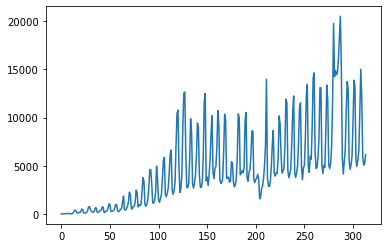

In [167]:
days_df['rides'].plot()

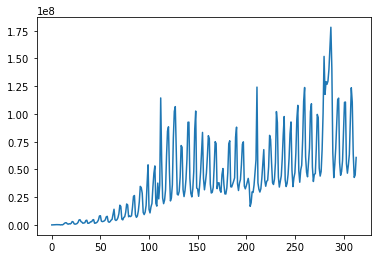

In [168]:
days_df['distance'].plot()

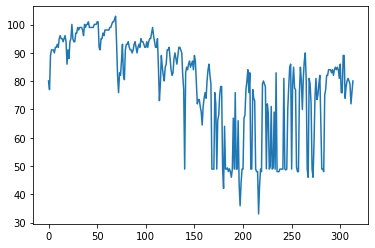

In [169]:
days_df['temp_max'].plot()

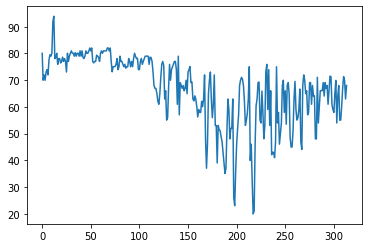

In [170]:
days_df['temp_min'].plot()

In [162]:
print(f"Start Date: {days_df['date'].min()}")
print(f"End Date: {days_df['date'].max()}")

Start Date: 2016-06-04
End Date: 2017-04-13


# Once initial preprocessing code written, add status/car_category to data

In [3]:
# CHANGES:
# Added case statement for car_category
# Added filters for car_category and status
# Added car_category to final query

start_time = time.time()

query = '''
    WITH rides AS (
        SELECT
             a.RIDE_ID                                      AS ride_id
            ,DATE(created_date)                             AS date
            ,SUBSTR(created_date, 11, 2)                    AS hour
            ,distance_travelled                             AS distance
            ,start_location_lat                             AS start_lat
            ,start_location_long                            AS start_long
            ,end_location_lat                               AS end_lat
            ,end_location_long                              AS end_long
            ,round_up_amount                                AS charity_amount
            ,(CASE
                WHEN requested_car_category = "b'LUXURY'"
                    THEN "b'PREMIUM'"
                ELSE requested_car_category
              END)                                          AS car_category
            ,make                                           AS car_make
            ,model                                          AS car_model
            ,HOURLYVISIBILITY                               AS hourly_visibility
            ,HOURLYDRYBULBTEMPC                             AS hourly_temp
            ,HOURLYRelativeHumidity                         AS hourly_humidity
            ,HOURLYWindSpeed                                AS hourly_wind_speed
            ,HOURLYWindDirection                            AS hourly_wind_direction
            ,HOURLYPrecip                                   AS hourly_precip
        FROM rides_a a
            INNER JOIN rides_b b
                ON a.RIDE_ID = b.RIDE_ID
            INNER JOIN weather w
                ON a.RIDE_ID = w.RIDE_ID
        WHERE requested_car_category <> "b'HONDA'"
            AND status = "b'DISPATCHED'"
    ),
    -- NOTE:
    -- This will only contain weather for hours in which a ride occurred.
    hourly_weather AS (
        SELECT
             date
            ,hour
            ,MAX(hourly_visibility) AS visibility
            ,MAX(hourly_temp) AS temp
            ,MAX(hourly_humidity) AS humidity
            ,MAX(hourly_wind_speed) AS wind_speed
            ,MAX(hourly_wind_direction) AS wind_direction
            ,MAX(hourly_precip) AS precip
        FROM rides
        GROUP BY date, hour
    ),
    daily_weather AS (
        SELECT
             date
            ,AVG(visibility) AS visibility
            ,MAX(temp)       AS temp_max
            ,MIN(temp)       AS temp_min
            ,AVG(humidity)   AS humidity
            ,AVG(wind_speed) AS wind_speed
            ,SUM(precip)     AS precip
        FROM hourly_weather
        GROUP BY date
    )
    SELECT
         r.ride_id
        ,r.date
        ,r.car_category
        ,r.distance
        ,r.charity_amount
        ,dw.visibility    AS daily_visibility
        ,dw.temp_max      AS daily_temp_max
        ,dw.temp_min      AS daily_temp_min
        ,dw.humidity      AS daily_humidity
        ,dw.wind_speed    AS daily_wind_speed
        ,dw.precip        AS daily_precip
    FROM rides r
        INNER JOIN daily_weather dw
            ON r.date = dw.date
'''

conn = sqlite3.connect('msda_workshop')
rides_df = pd.read_sql_query(query, conn)
conn.close()

disp(rides_df)

print(time.time() - start_time)

(1044157, 11)


,ride_id,date,car_category,distance,charity_amount,daily_visibility,daily_temp_max,daily_temp_min,daily_humidity,daily_wind_speed,daily_precip
0,0,2016-06-04,b'REGULAR',8459.0,,9.375,26.7,26.7,79.0,8.5,0.0
1,1,2016-06-04,b'REGULAR',443.0,,9.375,26.7,26.7,79.0,8.5,0.0
2,2,2016-06-04,b'REGULAR',568.0,,9.375,26.7,26.7,79.0,8.5,0.0
3,3,2016-06-04,b'REGULAR',4051.0,,9.375,26.7,26.7,79.0,8.5,0.0
4,4,2016-06-04,b'REGULAR',790.0,,9.375,26.7,26.7,79.0,8.5,0.0


23.17877984046936


# Write Preprocessing Function (and all future preprocessing steps)

### TODO: Create spreadsheet to illustrate the Data Scaffold

In [4]:
def celsius_to_fahrenheit(temp_c):
    temp_f = (temp_c * 1.8) + 32
    return temp_f

def clean_b_string(string):
    start = 2
    end = len(string) - 1
    clean_string = string[start:end]
    return clean_string

def preprocess_df(df_orig):
    df = df_orig.copy()
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['car_category'] = df['car_category'].apply(clean_b_string)
    df['distance'] = df['distance'].replace('', '0').astype(float)
    df['charity_amount'] = df['charity_amount'].replace('', '0').astype(float)
    df['daily_temp_max'] = df['daily_temp_max'].astype(float)
    df['daily_temp_min'] = df['daily_temp_min'].astype(float)
    df['daily_temp_max_f'] = df['daily_temp_max'].apply(celsius_to_fahrenheit)
    df['daily_temp_min_f'] = df['daily_temp_min'].apply(celsius_to_fahrenheit)
    
    days_df = df.groupby(['date', 'car_category']).agg(
        rides = ('date', 'count'),
        distance = ('distance', 'sum'),
        charity_amount = ('charity_amount', 'sum'),
        visibility = ('daily_visibility', 'max'),
        temp_max = ('daily_temp_max', 'max'),
        temp_min = ('daily_temp_min', 'max'),
        humidity = ('daily_humidity', 'max'),
        wind_speed = ('daily_wind_speed', 'max'),
        precip = ('daily_precip', 'max')
    ).reset_index()
    
    scaffold = pd.DataFrame(columns=['car_category', 'date'])

    for cat in days_df['car_category'].unique():
        start = days_df.loc[days_df['car_category'] == cat, 'date'].min()
        end = days_df.loc[days_df['car_category'] == cat, 'date'].max()
        scaffold_cat = pd.DataFrame({'car_category': cat, 'date': pd.date_range(start, end)})
        scaffold = pd.concat([scaffold, scaffold_cat]).reset_index(drop=True)
    
    scaffold['date'] = scaffold['date'].dt.date
    days_df = scaffold.merge(days_df, on=['car_category', 'date'], how='left')
    
    weather_df = days_df.groupby(['date']).agg(
        visibility = ('visibility', 'max'),
        temp_max = ('temp_max', 'max'),
        temp_min = ('temp_min', 'max'),
        humidity = ('humidity', 'max'),
        wind_speed = ('wind_speed', 'max'),
        precip = ('precip', 'max')
    ).reset_index()
    
    days_df_final = days_df[['car_category', 'date', 'rides', 'distance', 'charity_amount']]
    days_df_final = days_df_final.merge(weather_df, on='date', how='inner')
    fill_na_cols = ['rides', 'distance', 'charity_amount']
    days_df_final[fill_na_cols] = days_df_final[fill_na_cols].fillna(0)
    
    return days_df_final

In [5]:
df = preprocess_df(rides_df)

disp(df)

(886, 11)


,car_category,date,rides,distance,charity_amount,visibility,temp_max,temp_min,humidity,wind_speed,precip
0,REGULAR,2016-06-04,5.0,14311.0,0.0,9.375000,26.7,26.7,79.000000,8.500000,0.0
1,REGULAR,2016-06-05,5.0,29552.0,0.0,10.000000,23.3,20.0,76.666667,4.666667,0.0
2,REGULAR,2016-06-06,13.0,63948.0,0.0,10.000000,31.7,22.2,55.333333,6.000000,0.0
3,REGULAR,2016-06-07,10.0,97444.0,0.0,10.000000,32.8,21.1,70.666667,2.666667,0.0
4,REGULAR,2016-06-08,23.0,141151.0,0.0,9.666667,32.8,22.8,76.333333,4.666667,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 885
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   car_category    886 non-null    object 
 1   date            886 non-null    object 
 2   rides           886 non-null    float64
 3   distance        886 non-null    float64
 4   charity_amount  886 non-null    float64
 5   visibility      886 non-null    float64
 6   temp_max        886 non-null    float64
 7   temp_min        886 non-null    float64
 8   humidity        886 non-null    float64
 9   wind_speed      886 non-null    float64
 10  precip          886 non-null    float64
dtypes: float64(9), object(2)
memory usage: 83.1+ KB


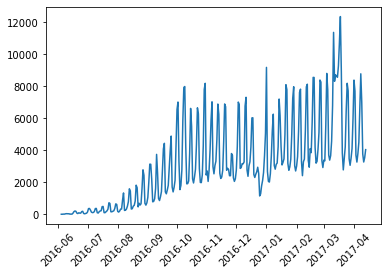

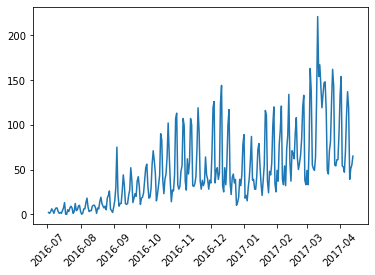

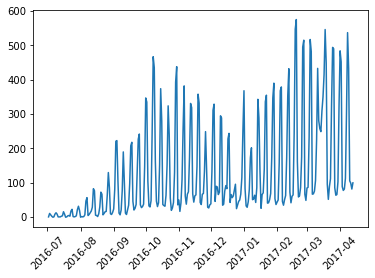

In [7]:
for cat in df['car_category'].unique():
    df_cat = df[df['car_category'] == cat]
    fig, ax = plt.subplots()
    plt.plot(df_cat['date'], df_cat['rides'])
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)
    plt.show()

# Forecasting

### Reduce to 1 category, univariate

In [8]:
prophet_df = df[df['car_category'] == 'REGULAR'][['date', 'rides']].rename(columns={'date': 'ds', 'rides': 'y'})

disp(prophet_df)

(314, 2)


,ds,y
0,2016-06-04,5.0
1,2016-06-05,5.0
2,2016-06-06,13.0
3,2016-06-07,10.0
4,2016-06-08,23.0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/srv/conda/envs/notebook/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/srv/conda/envs/notebook/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/srv/conda/envs/notebook/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


Christmas Day                 1.119505
New Year's Day                0.712999
Columbus Day                  0.404734
Christmas Day (Observed)      0.238185
Labor Day                     0.132516
Martin Luther King Jr. Day    0.120104
New Year's Day (Observed)     0.077341
Thanksgiving                  0.070765
Washington's Birthday         0.065032
Veterans Day                  0.052816
Independence Day              0.001529
Veterans Day (Observed)       0.000000
Memorial Day                  0.000000
dtype: float64


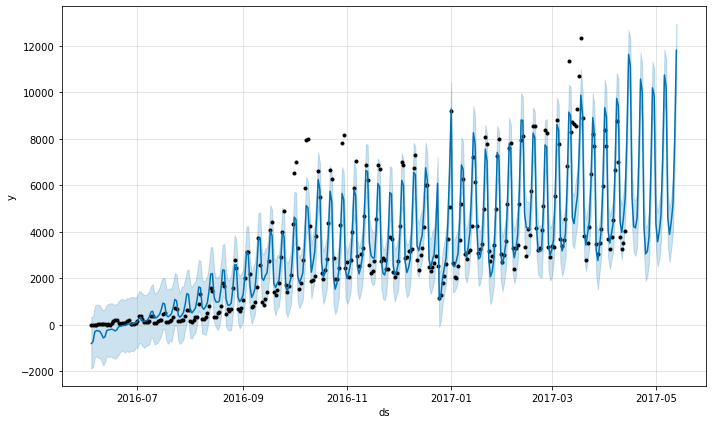

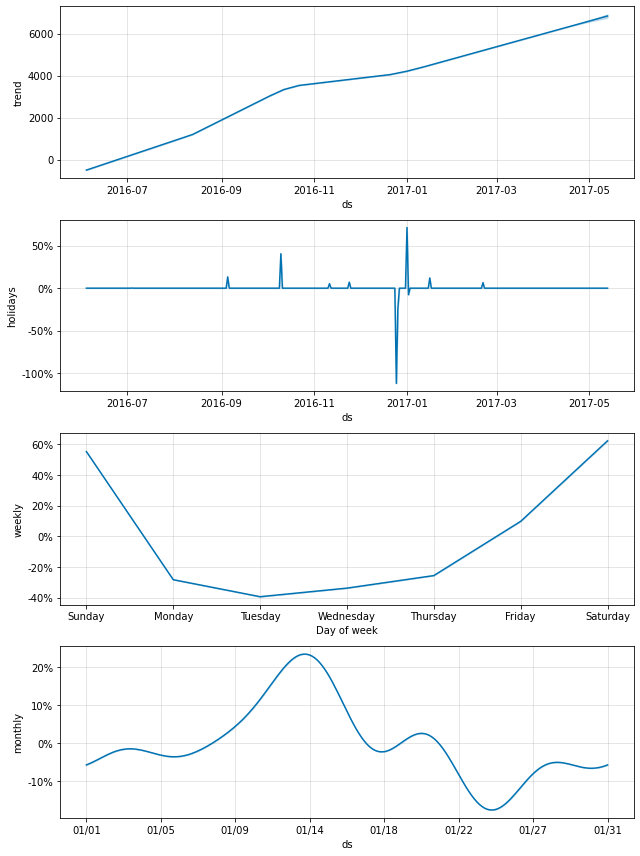

In [9]:
# Initialize model
m = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_country_holidays(country_name='US')
holiday_cols = ['Christmas Day', 'Christmas Day (Observed)', 'Columbus Day', 'Independence Day', 'Labor Day', 
                'Martin Luther King Jr. Day', 'Memorial Day', "New Year's Day", "New Year's Day (Observed)", 'Thanksgiving', 'Veterans Day', 
                'Veterans Day (Observed)', "Washington's Birthday"]

horizon = 30
m.fit(prophet_df)
future = m.make_future_dataframe(periods=horizon, freq='D')
pred = m.predict(future)

fig = m.plot(pred);
m.plot_components(pred);
print(abs(pred[holiday_cols]).max().sort_values(ascending=False));


In [10]:
df_cv = cross_validation(m, initial='253 days', horizon = '60 days')

disp(df_cv)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-02-12 00:00:00 and 2017-02-12 00:00:00



(60, 6)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,3076.496005,2358.673865,3757.369497,3368.0,2017-02-12
1,2017-02-14,2553.998181,1849.502349,3285.457705,2944.0,2017-02-12
2,2017-02-15,2741.507982,1998.385637,3422.460360,4105.0,2017-02-12
3,2017-02-16,3124.974589,2451.112930,3778.769587,3853.0,2017-02-12
4,2017-02-17,4832.419162,4124.688854,5569.290664,5751.0,2017-02-12


In [11]:
df_p = performance_metrics(df_cv)

df_p.tail(1)

,horizon,mse,rmse,mae,mape,mdape,coverage
54,60 days,1.104222e+06,1050.819462,589.89529,0.101919,0.067846,0.833333


In [12]:
disp(prophet_df)

(314, 2)


,ds,y
0,2016-06-04,5.0
1,2016-06-05,5.0
2,2016-06-06,13.0
3,2016-06-07,10.0
4,2016-06-08,23.0


### Add regressors

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/srv/conda/envs/notebook/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/srv/conda/envs/notebook/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/srv/conda/envs/notebook/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/srv/conda/envs/notebook/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


Christmas Day                 0.286588
Labor Day                     0.225342
New Year's Day                0.190520
Martin Luther King Jr. Day    0.151802
Veterans Day                  0.095725
Columbus Day                  0.087903
Washington's Birthday         0.057396
Christmas Day (Observed)      0.043117
Independence Day              0.030991
Thanksgiving                  0.019342
New Year's Day (Observed)     0.010858
Veterans Day (Observed)       0.000000
Memorial Day                  0.000000
dtype: float64


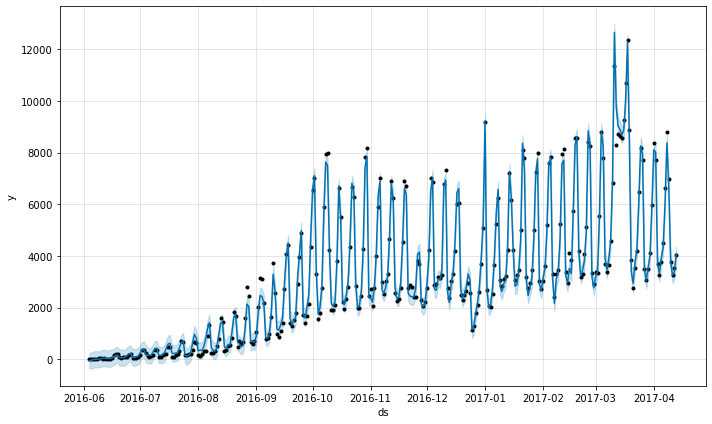

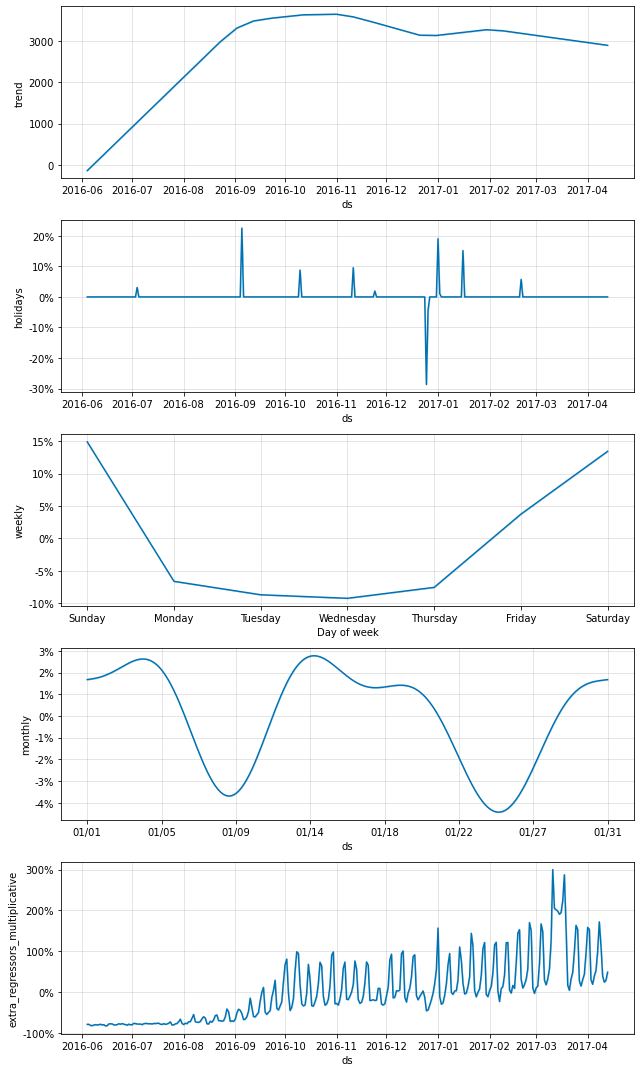

In [13]:
# Create df
prophet_df = df[df['car_category'] == 'REGULAR'].rename(columns={'date': 'ds', 'rides': 'y'}).drop(['car_category', 'distance'], axis=1)
X = prophet_df.drop(['ds', 'y'], axis=1)

# Initialize model
m = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_country_holidays(country_name='US')
holiday_cols = ['Christmas Day', 'Christmas Day (Observed)', 'Columbus Day', 'Independence Day', 'Labor Day', 
                'Martin Luther King Jr. Day', 'Memorial Day', "New Year's Day", "New Year's Day (Observed)", 'Thanksgiving', 'Veterans Day', 
                'Veterans Day (Observed)', "Washington's Birthday"]

# Add regressors
for col in X:
    m.add_regressor(col)

# Fit model
horizon = 30
m.fit(prophet_df)

# Create future dataframe
future = m.make_future_dataframe(periods=horizon, freq='D')
future['ds'] = future['ds'].dt.date
future = future.merge(prophet_df.drop('y', axis=1), on='ds', how='inner')

# Predict
pred = m.predict(future)

# Output
fig = m.plot(pred);
m.plot_components(pred);
print(abs(pred[holiday_cols]).max().sort_values(ascending=False));

In [14]:
df_cv = cross_validation(m, initial='253 days', horizon = '60 days')
df_p = performance_metrics(df_cv)

df_p.tail(1)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-02-12 00:00:00 and 2017-02-12 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
54,60 days,2.704302e+06,1644.476271,1608.483589,0.340763,0.360992,0.0


In [15]:
disp(df_cv)

(60, 6)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,3337.101578,3126.361910,3564.440456,3368.0,2017-02-12
1,2017-02-14,3153.178393,2925.747789,3375.182672,2944.0,2017-02-12
2,2017-02-15,3706.766511,3482.361466,3929.700300,4105.0,2017-02-12
3,2017-02-16,3473.866928,3271.798803,3703.120982,3853.0,2017-02-12
4,2017-02-17,5920.939867,5700.134222,6146.193512,5751.0,2017-02-12


# Walk-Forward Evaluation

### Model Eval Functions

In [16]:
def root_mean_squared_error(y_true, y_pred):
    result = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return np.round(result, 3)

def mean_forecast_error(y_true, y_pred):
    result = np.mean(y_true - y_pred)
    return np.round(result, 20)

def mean_absolute_error(y_true, y_pred):
    result = np.mean(np.abs(y_true - y_pred))
    return np.round(result, 3)

def mean_absolute_percentage_error(y_true, y_pred, zero_method='adjust', adj=0.1):
    if zero_method == 'adjust':
        y_true_adj = y_true.copy()
        y_true_adj[y_true_adj == 0] = adj
        result = np.mean(np.abs((y_true_adj - y_pred) / y_true_adj)) * 100

    elif zero_method == 'error':
        if len(y_true[y_true == 0]) > 0:
            raise ValueError('Input y_true array contains a zero.')
        else:
            result = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    elif zero_method == 'ignore':
        y_true_ign = y_true.copy()
        y_true_ign = y_true_ign[y_true_ign != 0]
        result = np.mean(np.abs((y_true_ign - y_pred) / y_true_ign)) * 100

    else:
        raise ValueError("Invalid zero_method value - must be 'adjust', 'error', or 'ignore'.")

    return np.round(result, 3)

In [25]:
def add_endog_vars(df, day_of_week=False):
    # Simple lag and difference for y
    df['y_lag_1'] = df['y'].shift(1)
    df['y_lag_diff_1'] = df['y_lag_1'].diff(1)

    # Add day of week, if needed
    # Day 0 = Monday
    if day_of_week:
        df['day_of_week'] = pd.to_datetime(df['ds']).dt.dayofweek
        df = pd.get_dummies(df, prefix='day_', columns=['day_of_week'])
    
    # Remove rows without full data
    df = df.dropna(0).reset_index(drop=True)

    return df


def train_prophet(df, model, date_list):
    df = add_endog_vars(df)
    X = df.drop(['ds', 'y'], axis=1)
    y_pred_list = []
    horizon = 1

    for d in date_list:
        print(f'Fitting model to forecast {d}')

        model_copy = copy.copy(model)
        for col in X:
            model_copy.add_regressor(col)

        # Split train and test
        idx = df[df['ds'] == d].index[0]
        train, test = df[0:idx], df[idx:(idx + horizon)].drop('y', axis=1)

        # Fit and predict
        try:
            model_copy.fit(train)
            pred = model_copy.predict(test)
            y_pred_list.append(pred['yhat'])
        except:
            print(f'Error fitting model for {d}')
            sys.exit()

    return y_pred_list


def train_non_prophet(df, model, date_list):
    df = add_endog_vars(df, day_of_week=True)
    y = df['y']
    X = df.drop(['ds', 'y'], axis=1)
    y_pred_list = []
    horizon = 1

    for d in date_list:
        print(f'Fitting model to forecast {d}')

        # Split train and test
        idx = df[df['ds'] == d].index[0]
        y_train, X_train = y[0:idx], X[0:idx]
        y_test, X_test = y[idx:(idx + horizon)], X[idx:(idx + horizon)]

        # Fit and predict
        try:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)[0]
            y_pred_list.append(pred)
        except:
            print(f'Error fitting model for {d}')
            sys.exit()

    return y_pred_list


def walk_forward_evaluation(df, model, first_test_day, plot_title):
    # Set up for daily evaluation
    date_list = list(pd.Series(pd.date_range(start=first_test_day, end=df['ds'].max())).dt.date)

    if isinstance(model, fbprophet.forecaster.Prophet):
        y_pred = train_prophet(df, model, date_list)
    else:
        y_pred = train_non_prophet(df, model, date_list)

    # Create results df
    test_df = df[df['ds'] >= first_test_day]
    results = pd.DataFrame({'ds': test_df['ds'], 'actual': test_df['y'], 'pred': y_pred})

    # Plot results
    plt.plot(results['actual'])
    plt.plot(results['pred'], 'r--', alpha=0.8)
    plt.legend(['Actual GMR', 'Predicted GMR'])
    plt.title(plot_title)
    plt.show()

    # Accuracy
    metrics_dict = {}
    metrics_dict['mape'] = mean_absolute_percentage_error(results['actual'], results['pred'])
    metrics_dict['rmse'] = root_mean_squared_error(results['actual'], results['pred'])
    metrics_dict['mae'] = mean_absolute_error(results['actual'], results['pred'])
    metrics_dict['mfe'] = mean_forecast_error(results['actual'], results['pred'])

    return results, metrics_dict


def fit_forecasters(df, model_dict, first_test_day):
    for model_name in model_dict.keys():
        c.start()
        print(f'Fitting {model_name}')
        model = model_dict[model_name]['model']
        plot_title = model_dict[model_name]['label']

        results, metrics = walk_forward_evaluation(df, model, first_test_day, plot_title)
        model_dict[model_name]['results'] = results
        model_dict[model_name]['metrics'] = metrics
        c.stop()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-04


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-05


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-06


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-07


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-08


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-09


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-11


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-12


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-13


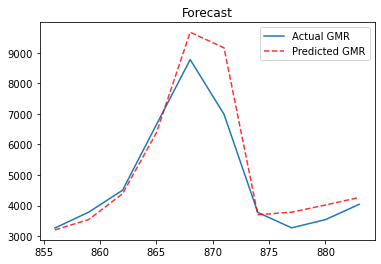

             ds  actual                                         pred
856  2017-04-04  3264.0   0    3201.59594
Name: yhat, dtype: float64
859  2017-04-05  3784.0  0    3541.427351
Name: yhat, dtype: float64
862  2017-04-06  4501.0  0    4385.277778
Name: yhat, dtype: float64
865  2017-04-07  6646.0  0    6381.485556
Name: yhat, dtype: float64
868  2017-04-08  8780.0  0    9675.433928
Name: yhat, dtype: float64
871  2017-04-09  6989.0  0    9165.871677
Name: yhat, dtype: float64
874  2017-04-10  3773.0  0    3699.151925
Name: yhat, dtype: float64
877  2017-04-11  3269.0  0    3782.310186
Name: yhat, dtype: float64
880  2017-04-12  3539.0  0    4017.486401
Name: yhat, dtype: float64
883  2017-04-13  4041.0  0    4264.862695
Name: yhat, dtype: float64
{'mape': 9.294, 'rmse': 789.599, 'mae': 504.703, 'mfe': -352.8903436348738}
17.98713


In [18]:
c.start()

drop_cols = ['car_category', 'distance', 'charity_amount']
prophet_df = df[df['car_category'] == 'REGULAR'].rename(columns={'date': 'ds', 'rides': 'y'}).drop(drop_cols, axis=1)

model = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_country_holidays(country_name='US')
title = 'Forecast'
first_test_day = datetime.date(2017, 4, 4)
results, metrics = walk_forward_evaluation(prophet_df, model, first_test_day=first_test_day, plot_title=title)
print(results)
print(metrics)

c.stop()

### Time to try XGBoost

Fitting model to forecast 2017-04-04
Fitting model to forecast 2017-04-05
Fitting model to forecast 2017-04-06
Fitting model to forecast 2017-04-07
Fitting model to forecast 2017-04-08
Fitting model to forecast 2017-04-09
Fitting model to forecast 2017-04-10
Fitting model to forecast 2017-04-11
Fitting model to forecast 2017-04-12
Fitting model to forecast 2017-04-13


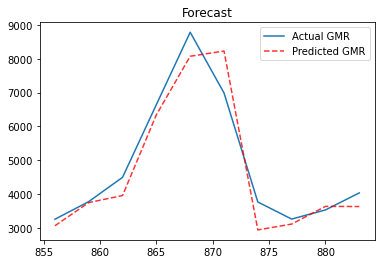

             ds  actual         pred
856  2017-04-04  3264.0  [3070.9204]
859  2017-04-05  3784.0  [3755.5615]
862  2017-04-06  4501.0   [3963.691]
865  2017-04-07  6646.0   [6344.196]
868  2017-04-08  8780.0  [8072.1094]
871  2017-04-09  6989.0   [8225.007]
874  2017-04-10  3773.0  [2949.1584]
877  2017-04-11  3269.0   [3121.622]
880  2017-04-12  3539.0   [3643.583]
883  2017-04-13  4041.0  [3638.9805]
{'mape': array([8.814], dtype=float32), 'rmse': array([576.168], dtype=float32), 'mae': array([448.235], dtype=float32), 'mfe': array([180.11711], dtype=float32)}
1488.29298


In [19]:
c.start()

drop_cols = ['car_category', 'distance', 'charity_amount']
xgb_df = df[df['car_category'] == 'REGULAR'].rename(columns={'date': 'ds', 'rides': 'y'}).drop(drop_cols, axis=1)

model = xgb.XGBRegressor(n_estimators=100, reg_lambda=1, gamma=0, max_depth=3)
title = 'Forecast'
first_test_day = datetime.date(2017, 4, 4)
results, metrics = walk_forward_evaluation(xgb_df, model, first_test_day, plot_title=title)
print(results)
print(metrics)

c.stop()

### Evaluate both models

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting prophet
Fitting model to forecast 2017-04-12


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting model to forecast 2017-04-13


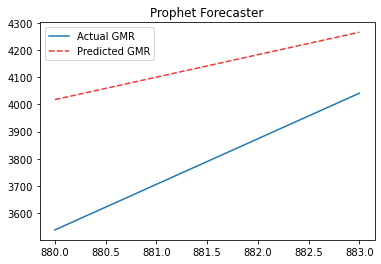

3.70748
Fitting xgboost
Fitting model to forecast 2017-04-12
Fitting model to forecast 2017-04-13


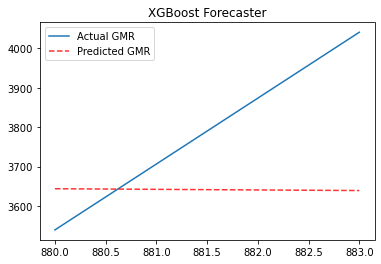

288.33325


In [34]:
# Create Prophet model
forecaster_prophet = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
forecaster_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecaster_prophet.add_country_holidays(country_name='US')

# Create XGBoost model
forecaster_xgb = xgb.XGBRegressor(n_estimators=100, reg_lambda=1, gamma=0, max_depth=3)

# Create model dictionary for evaluation
model_dict = {
        'prophet': {
            'label': 'Prophet Forecaster',
            'model': forecaster_prophet,
            'results': None,
            'metrics': None
        },
        'xgboost': {
            'label': 'XGBoost Forecaster',
            'model': forecaster_xgb,
            'results': None,
            'metrics': None
        }
    }

# Run evaluation
first_test_day = datetime.date(2017, 4, 12)
drop_cols = ['car_category', 'distance', 'charity_amount']
input_df = df[df['car_category'] == 'REGULAR'].rename(columns={'date': 'ds', 'rides': 'y'}).drop(drop_cols, axis=1)
fit_forecasters(input_df, model_dict, first_test_day)

for model in model_dict.keys():
    print(model)
    print(model_dict[model]['metrics'])

In [37]:
for model in model_dict.keys():
    print(model)
    print(model_dict[model]['metrics'])

prophet
{'mape': 9.53, 'rmse': 373.54, 'mae': 351.175, 'mfe': -351.1745479440315}
xgboost
{'mape': 6.452, 'rmse': 293.732, 'mae': 253.301, 'mfe': 148.71826171875}
